In [1]:
import scanpy as sc
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import anndata2ri
import logging
from scipy.sparse import issparse

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    # color_map="YlGnBu",
    frameon=False,
)

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

/tmp/ipykernel_1279405/1527554728.py:22: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [3]:
adata = sc.read(
    filename="dataset/s4d8_quality_control.h5ad",
    # backup_url="https://figshare.com/ndownloader/files/40014331",
)

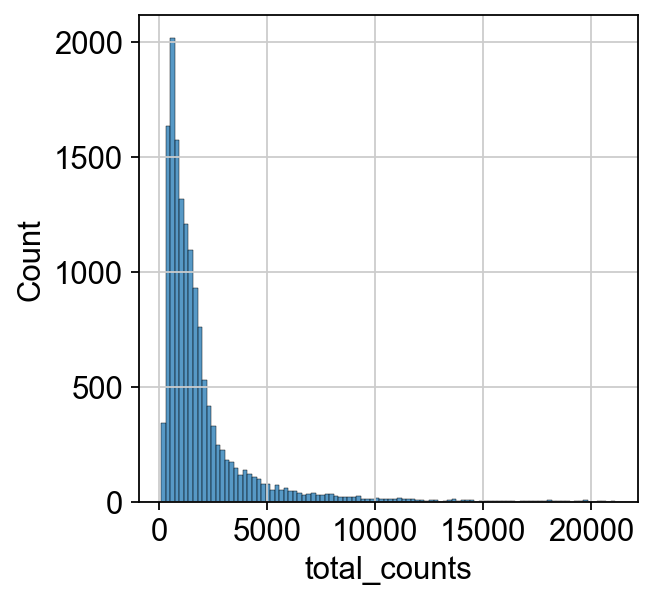

In [4]:
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False)

In [5]:
adata

AnnData object with n_obs × n_vars = 14814 × 20171
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    layers: 'counts', 'soupX_counts'

**Three different normalization techniques:**
 - the shifted logarithm transformation
   - works beneficial for stabilizing variance for subsequent dimensionality reduction and identification of differentially expressed genes
 - scran normalization
   - Scran was extensively tested and used for batch correction tasks
 - analytic approximation of Pearson residuals.
   - Pearson residuals are well suited for selecting biologically variable genes and identification of rare cell types.

# Shifted logarithm

In [6]:
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

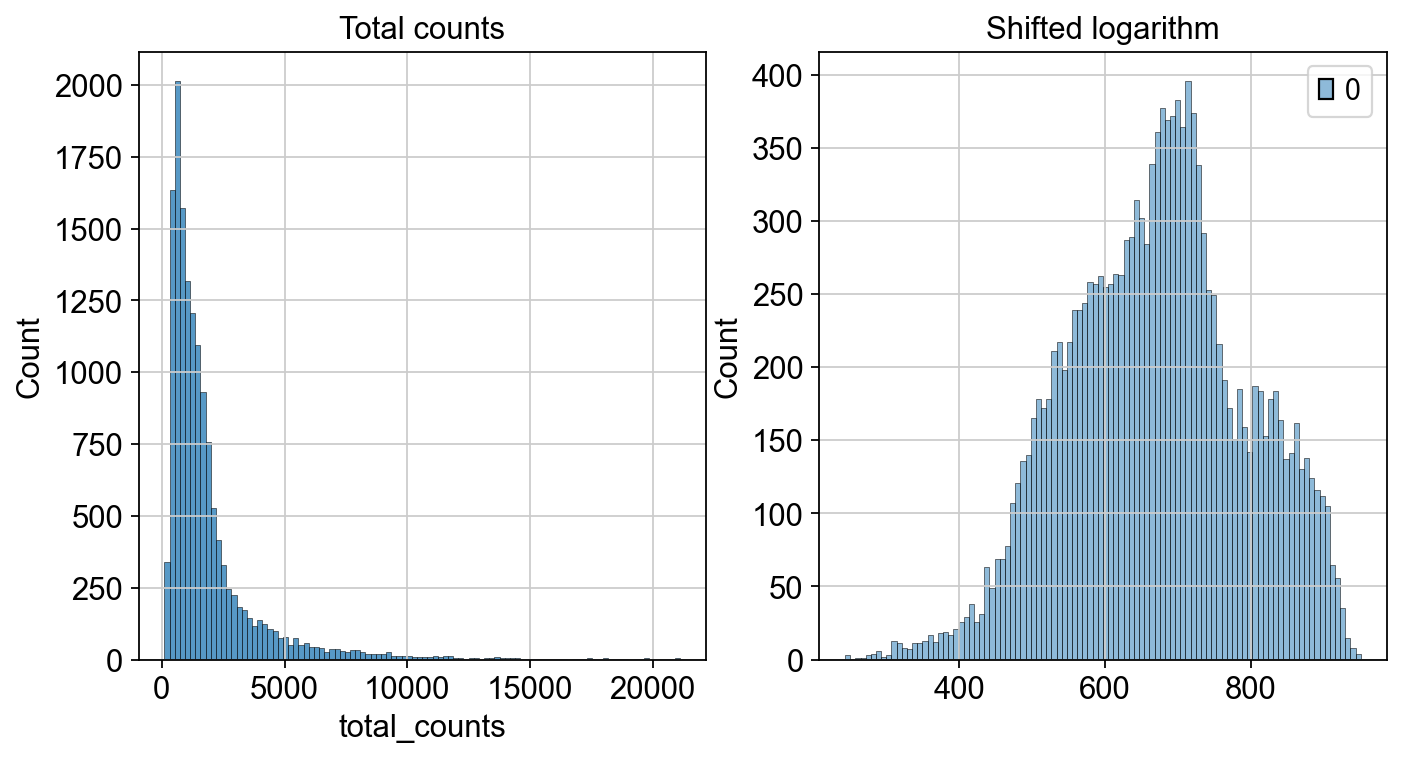

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

# SCARN

In [8]:
#  Scran leverages a deconvolution approach to 
#  estimate the size factors based on a linear regression over genes for pools of cells

from scipy.sparse import csr_matrix, issparse

In [2]:
%%R
library(scran)
library(BiocParallel)

Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOr

In [10]:
# Preliminary clustering for differentiated normalisation
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="groups")

In [11]:
data_mat = adata_pp.X.T
# convert to CSC if possible. See https://github.com/MarioniLab/scran/issues/70
if issparse(data_mat):
    if data_mat.nnz > 2**31 - 1:
        data_mat = data_mat.tocoo()
    else:
        data_mat = data_mat.tocsc()
ro.globalenv["data_mat"] = data_mat
ro.globalenv["input_groups"] = adata_pp.obs["groups"]

In [12]:
del adata_pp

Read later:

https://bioconductor.org/packages/devel/bioc/vignettes/scran/inst/doc/scran.html

In [13]:
%%R -o size_factors

size_factors = sizeFactors(
    computeSumFactors(
        SingleCellExperiment(
            list(counts=data_mat)), 
            clusters = input_groups,
            min.mean = 0.1,
            BPPARAM = MulticoreParam()
    )
)

dimnames(.) <- NULL translated to
dimnames(.) <- list(NULL,NULL)


In [14]:
adata.obs["size_factors"] = size_factors
scran = adata.X / adata.obs["size_factors"].values[:, None]
adata.layers["scran_normalization"] = csr_matrix(sc.pp.log1p(scran))

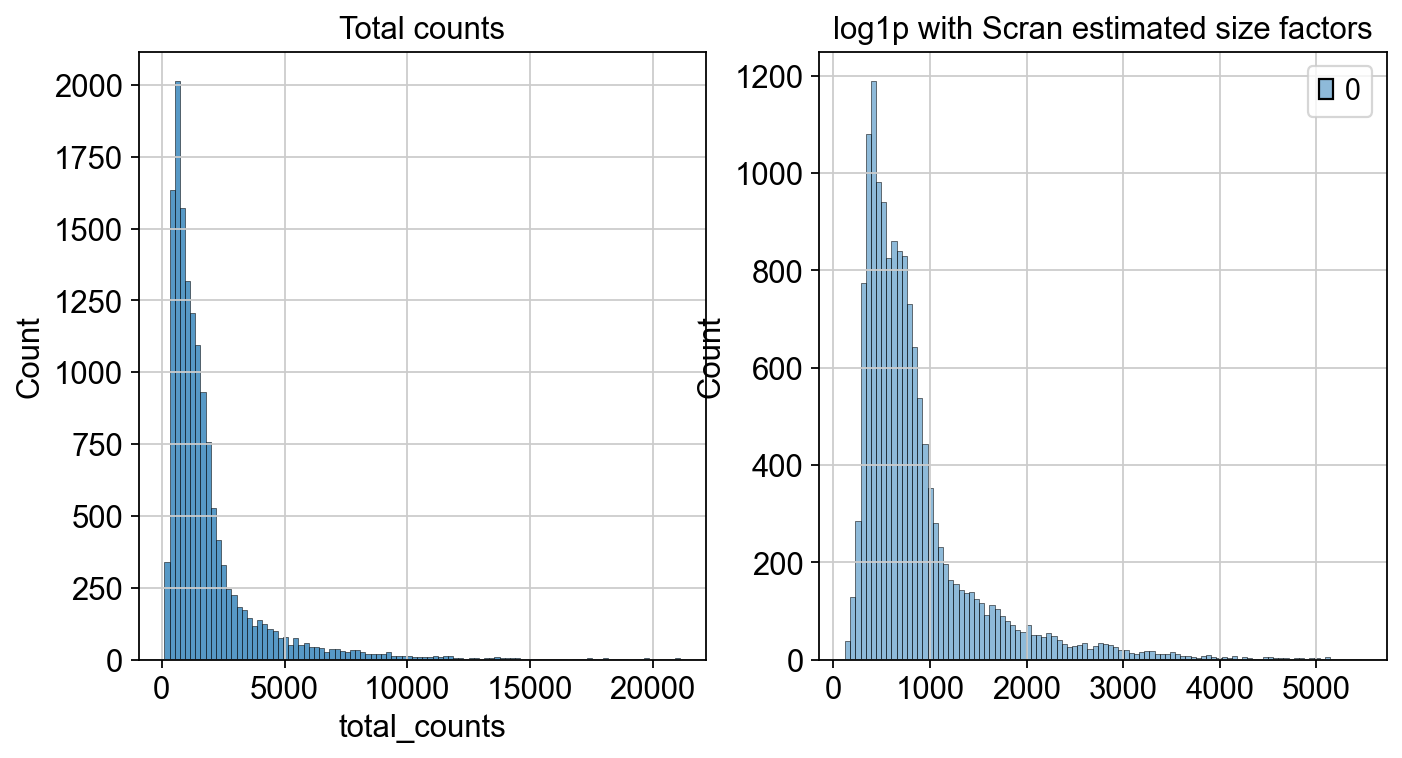

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(
    adata.layers["scran_normalization"].sum(1), bins=100, kde=False, ax=axes[1]
)
axes[1].set_title("log1p with Scran estimated size factors")
plt.show()

# Analytic Pearson residuals

In [16]:
analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata, inplace=False)
adata.layers["analytic_pearson_residuals"] = csr_matrix(analytic_pearson["X"])

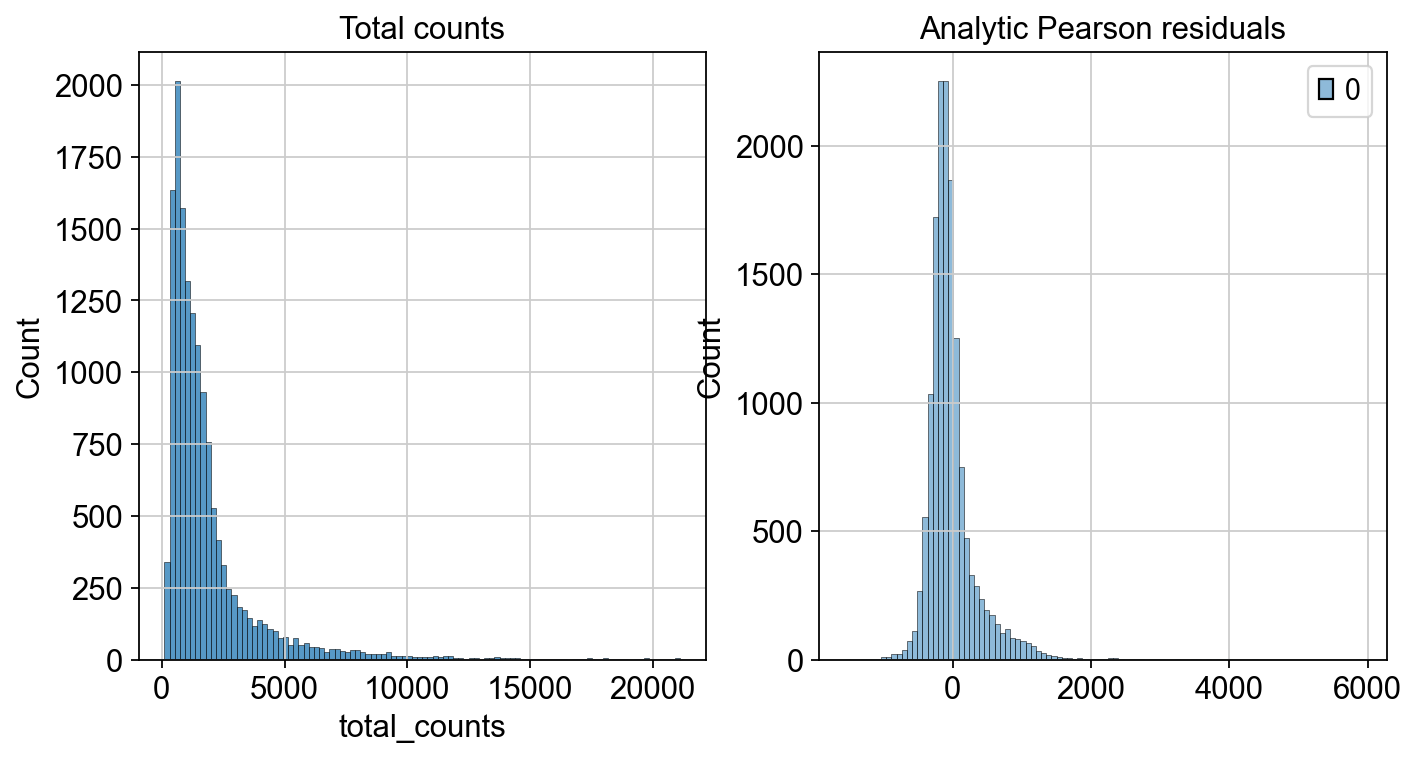

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(
    adata.layers["analytic_pearson_residuals"].sum(1), bins=100, kde=False, ax=axes[1]
)
axes[1].set_title("Analytic Pearson residuals")
plt.show()

In [18]:
adata.layers["analytic_pearson_residuals"].shape

(14814, 20171)

In [19]:
# adata.write("s4d8_normalization.h5ad")

In [3]:
import session_info

session_info.show()

In [4]:
%%R

sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 22.04.3 LTS

Matrix products: default
BLAS/LAPACK: /home/mowp/mambaforge/envs/sc/lib/libmkl_intel_lp64.so.2

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=zh_CN.UTF-8        LC_COLLATE=en_US.UTF-8    


 [5] LC_MONETARY=zh_CN.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=zh_CN.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=zh_CN.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    tools     stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] BiocParallel_1.32.5         scran_1.26.0               
 [3] scuttle_1.8.0               SingleCellExperiment_1.20.0
 [5] SummarizedExperiment_1.28.0 Biobase_2.58.0             
 [7] GenomicRanges_1.50.0        GenomeInfoDb_1.34.9        
 [9] IRanges_2.32.0              S4Vectors_0.36.0           
[11] BiocGenerics_0.44.0         MatrixGenerics_1.10.0      
[13] matrixStats_1.0.0          

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.11               compiler_4.2.3           
 [3] bluster_1.8.0             XVector_0.38.0           
 [5] bitops_1.0-7              BiocNeighbors_1.16.0     
